# Script used to perform regression, trying to predict the number of attaccks per state, per year.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./part/DF1sthypTOT')

In [3]:
df.head()

,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,MilitaryExp,Density,cnt
0,AFG,1960,32.328512,4.000000e+07,739462.0,8255331.0,551.1210,604.5970,51.276,2.252607e+10,13.891572,0.0
1,ALB,1960,62.254366,6.200000e+07,493982.0,1114818.0,151.0588,160.4806,42.240,2.252607e+10,55.962154,0.0
2,DZA,1960,46.135122,1.451501e+09,3394205.0,7730687.0,323.2800,373.1320,49.671,2.252607e+10,4.670910,0.0
3,AGO,1960,32.984829,1.451501e+09,550013.0,4720831.0,500.8860,565.4100,54.423,2.252607e+10,4.227837,0.0
4,ATG,1960,61.782732,1.451501e+09,21684.0,32997.0,244.9240,275.5520,32.920,2.252607e+10,123.433409,0.0


In [4]:
del df['CountryCode']

In [5]:
df.dtypes

Year                int64
SP.DYN.LE00.IN    float64
MS.MIL.MPRT.KD    float64
SP.URB.TOTL       float64
SP.RUR.TOTL       float64
SP.DYN.AMRT.FE    float64
SP.DYN.AMRT.MA    float64
SP.DYN.CBRT.IN    float64
MilitaryExp       float64
Density           float64
cnt               float64
dtype: object

In [6]:
df.describe()

,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,MilitaryExp,Density,cnt
count,9675.000000,9675.000000,9.675000e+03,9.675000e+03,9.675000e+03,9675.000000,9675.000000,9675.000000,9.675000e+03,9675.000000,9675.000000
mean,1986.390698,63.051208,8.126313e+08,1.151509e+07,1.518205e+07,199.607566,270.397297,30.040825,1.143548e+10,218.366585,12.366408
std,15.461280,11.333782,6.941853e+08,3.798078e+07,7.352284e+07,123.317763,117.642358,13.020843,2.374492e+10,1079.839746,74.534341
min,1960.000000,19.265512,0.000000e+00,6.627000e+03,0.000000e+00,29.171200,63.413000,6.900000,0.000000e+00,0.025899,0.000000
25%,1973.000000,54.847293,5.100000e+07,4.038695e+05,5.039915e+05,103.424500,182.181000,18.100000,1.425978e+08,15.926800,0.000000
50%,1986.000000,66.024927,9.780000e+08,1.994928e+06,2.519806e+06,159.363000,251.514000,30.063000,2.672286e+09,49.687727,0.000000
75%,2000.000000,71.670195,1.451501e+09,6.918278e+06,7.815200e+06,280.066500,341.427000,41.978500,2.252607e+10,117.831373,1.000000
max,2013.000000,83.831707,5.566000e+09,7.216918e+08,8.701360e+08,799.382000,921.630000,57.637000,6.980000e+11,20287.714286,2852.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d9c97a910>,
      dtype=object)

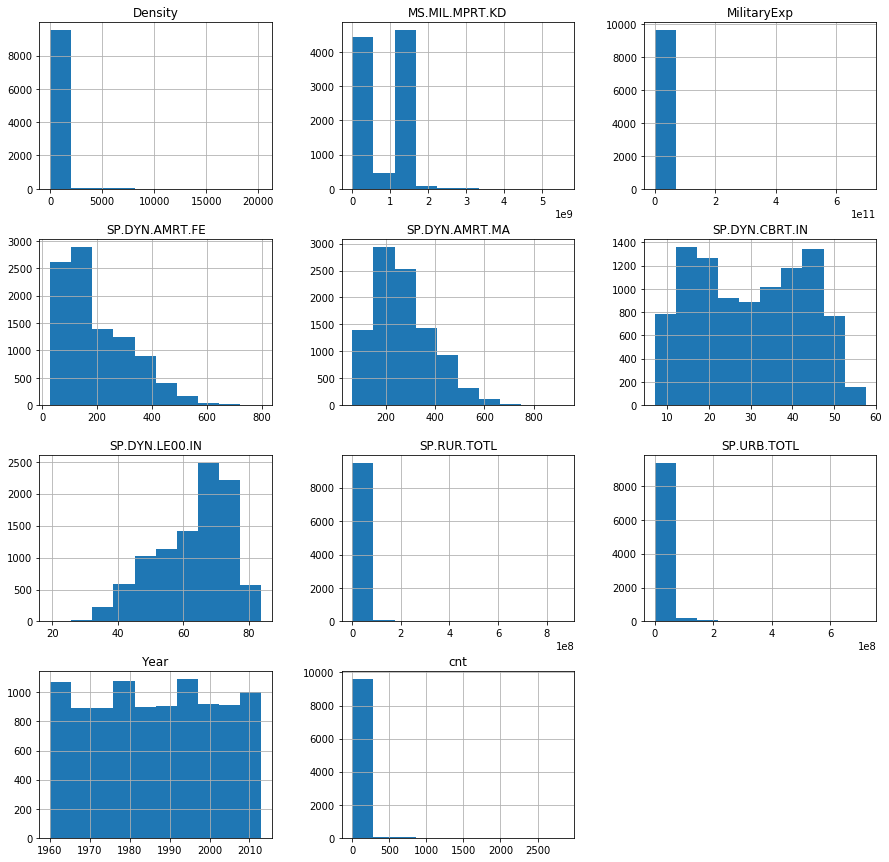

In [7]:
df.hist(figsize=(15,15))

In [52]:
df_std = df 

print('Shape of the df: ', df_std.shape)
print('Number of cnt = 0: ', df_std[df_std['cnt'] == 0].shape)

Shape of the df:  (9675, 11)
Number of cnt = 0:  (6719, 11)


#### We had a lot of values of cnt equal to zero. So we decided to delete all of them, focusing more on the other values of cnt.

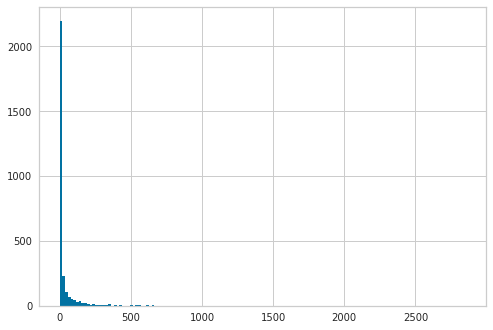

In [89]:
df_std = df_std[df_std['cnt'] > 0]
df_std['cnt'].hist(bins=150)

In [90]:
print('Shape of the df: ', df_std.shape)

Shape of the df:  (2956, 8)


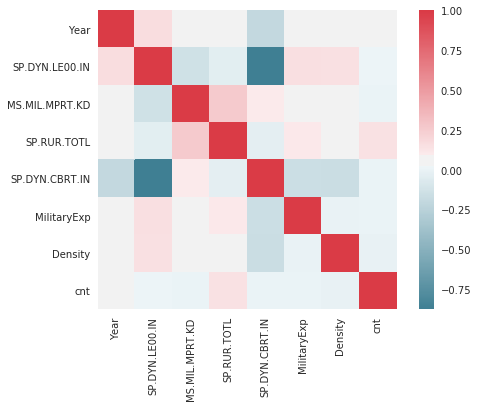

In [91]:
corr = df_std.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True), square=True)

In [92]:
del df_std['SP.URB.TOTL']
del df_std['SP.DYN.AMRT.FE']
del df_std['SP.DYN.AMRT.MA']

#we deleted them because of collinearity.


KeyError: 'SP.URB.TOTL'

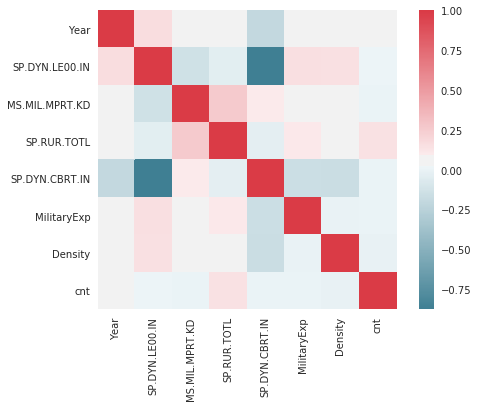

In [93]:
corr = df_std.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True), square=True)

In [94]:
from sklearn.model_selection import train_test_split

feature_matrix = df_std.loc[:, df_std.columns != 'cnt']
target_vector = df_std.cnt

x_train, x_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

In [95]:
x_train.shape

(2364, 7)

In [96]:
x_test.shape

(592, 7)

We performed the scaling, using the mean-variance scaling.

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale

x_train = pd.DataFrame(scale(x_train), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(scale(x_test), index=x_test.index, columns=x_test.columns)
model=LinearRegression(fit_intercept=True)
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [98]:
y_pred_train = model.predict(x_train)

In [99]:
y_pred_test = model.predict(x_test)

In [100]:
from sklearn import metrics

R2_base = metrics.r2_score(y_train, y_pred_train, sample_weight=None, multioutput='uniform_average')
R2 = metrics.r2_score(y_test, y_pred_test, sample_weight=None, multioutput='uniform_average')

print("R2 on train: ", R2_base)
print("R2 on test: ", R2)

R2 on train:  0.03939890440585114
R2 on test:  0.013058095276428316


In [101]:
coefficients = pd.Series(model.coef_, index=x_train.columns)
print('Coefficients: ')
print(coefficients)

Coefficients: 
Year              12.833686
SP.DYN.LE00.IN    14.025818
MS.MIL.MPRT.KD    -5.307681
SP.RUR.TOTL       22.991783
SP.DYN.CBRT.IN    17.085967
MilitaryExp       -1.602305
Density           -1.087881
dtype: float64


The results using the regression are so bad, so we tried with a polynomial model.

## Polynomial models applying k-Fold CV and Ridge regularization

In [102]:
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures as pol
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from statistics import mean 
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=5, shuffle=True, random_state=2) # we are setting 7 folds
feature_matrix=df_std.loc[:, df_std.columns != 'cnt']
target_vector=df_std['cnt']
MSE_tr, MSE_te = [], []
R2_tr, R2_te = [], []
kMSE_tr, kMSE_te = [],  []
kR2_tr, kR2_te = [], []
degrees = [1,2,3,4] # list of different degrees of freedom
for degree in degrees: # cycle which applies the different degrees of freedom
    for train_index, test_index in kf.split(feature_matrix): # cycle that performs KCV on a certain polynomial model
        x_train, x_test = feature_matrix.iloc[train_index], feature_matrix.iloc[test_index]
        y_train, y_test = target_vector.iloc[train_index], target_vector.iloc[test_index]

        x_train = pd.DataFrame(scale(x_train), index=x_train.index, columns=x_train.columns) # standardization
        #y_train = pd.DataFrame(scale(y_train), index=y_train.index).to_numpy() # standardization
        x_test = pd.DataFrame(scale(x_test), index=x_test.index, columns=x_test.columns) # standardization
        #y_test = pd.DataFrame(scale(y_test), index=y_test.index).to_numpy() # standardization

        model = make_pipeline(pol(degree), RidgeCV(alphas=(0.01,1.0,100), cv=4))
        x = model.fit(x_train, y_train.ravel())
        y_pred_on_training=model.predict(x_train)
        y_pred=model.predict(x_test)
        MSE_tr.append(metrics.mean_squared_error(y_train, y_pred_on_training, sample_weight=None, multioutput='uniform_average'))
        MSE_te.append(metrics.mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average'))
        R2_tr.append(metrics.r2_score(y_train, y_pred_on_training, sample_weight=None, multioutput='uniform_average'))
        R2_te.append(metrics.r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average'))
    kMSE_tr.append(mean(MSE_tr))
    kMSE_te.append(mean(MSE_te))
    kR2_tr.append(mean(R2_tr))
    kR2_te.append(mean(R2_te))
    MSE_tr = []
    MSE_te = []
    R2_tr = []
    R2_te = []
print('kMSE on training, from degree 1 to 4:\n', kMSE_tr)
print('\nkMSE on testing, from degree 1 to 4:\n', kMSE_te)
print('\nkR2 on training, from degree 1 to 4:\n', kR2_tr)
print('\nkR2 on testing, from degree 1 to 4:\n', kR2_te)

kMSE on training, from degree 1 to 4:
 [16435.714010387648, 15114.933131847, 13489.590937860525, 11595.188012986391]

kMSE on testing, from degree 1 to 4:
 [16548.597078154286, 15455.91950480327, 16458.05009679079, 105246.53212997339]

kR2 on training, from degree 1 to 4:
 [0.035668814882870395, 0.11317981633319782, 0.20834476336280255, 0.31901296231228343]

kR2 on testing, from degree 1 to 4:
 [0.027799698561985588, 0.09242201941110428, 0.022264856018897716, -5.4588299587530305]


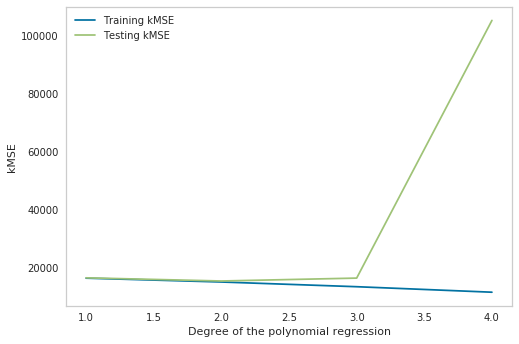

In [103]:
plt.plot(degrees, kMSE_tr, label='Training kMSE')
plt.plot(degrees, kMSE_te, label='Testing kMSE')
plt.xlabel('Degree of the polynomial regression')
plt.ylabel('kMSE')
plt.legend()
plt.grid()

plt.show()

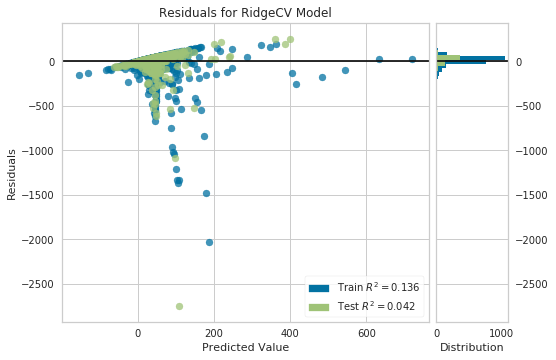

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import yellowbrick
from yellowbrick.regressor import ResidualsPlot

model = make_pipeline(pol(2), RidgeCV(alphas=(0.01,1.0,100), cv=4))

# Instantiate the linear model and visualizer

visualizer = ResidualsPlot(model)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

The best model was the polynomial with grade 3, resulting in a R2train = 0,30 and a R2test = 0,25. The results are still bad, so we decided to re-formulate the problem, passing at a classification problem.

In [152]:
df_class = df_std.rename(columns={'cnt':'conto'})

#### We are going to divide the data in 5 groups. 

Low number of attacks: 0 < cnt < 5

Low-medium number of attacks: 5 <= cnt < 15

Medium number of attacks: 15 <= cnt < 40

Medium-high number of attacks: 40 <= cnt < 120

High number of attacks: cnt >= 120

The splitting was made considering the fact that each cathegory had to be a good amount of sample.

In [153]:
df_class.groupby(by='conto').aggregate({'conto':'count'})

df_class['conto'] = df_class['conto'].apply(lambda x: 0 if (x > 0 and x < 2) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: -1 if (x >= 2 and x < 6) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: -2 if (x >= 6 and x < 25) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: -3 if (x >= 25 and x < 100) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: -4 if (x >= 100) else x)

df_class['conto'] = df_class['conto'].apply(lambda x: 1 if (x == -1) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: 2 if (x == -2) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: 3 if (x == -3) else x)
df_class['conto'] = df_class['conto'].apply(lambda x: 4 if (x == -4) else x)

df_class = df_class.rename(columns={'conto':'cnt'})

df_class

,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.RUR.TOTL,SP.DYN.CBRT.IN,MilitaryExp,Density,cnt
1795,1970,66.590829,2.530000e+08,5063111.0,22.759,4.457139e+08,8.664263,2.0
1798,1970,71.018537,2.400000e+08,1842906.0,20.600,1.277360e+09,1.627064,0.0
1806,1970,70.971951,5.280000e+08,594492.0,14.700,7.477551e+08,316.285017,0.0
1810,1970,45.655561,2.000000e+06,2713557.0,42.261,1.678714e+07,4.101453,0.0
1813,1970,59.150585,2.190000e+08,42319623.0,35.214,1.026234e+09,11.276180,2.0
...,...,...,...,...,...,...,...,...
9662,2013,75.175951,6.700000e+08,20725319.0,16.836,1.866257e+10,96.095470,3.0
9665,2013,77.195634,2.252000e+09,1357714.0,11.044,2.356106e+10,109.073094,0.0
9669,2013,74.074415,1.165000e+09,3362458.0,19.842,6.199698e+09,33.195598,0.0
9672,2013,63.583512,2.300000e+07,16992356.0,32.947,1.648751e+09,48.361113,4.0


Here we can see that each class has a good amount of samples.

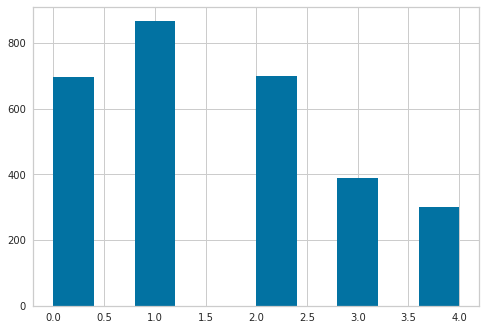

In [154]:
df_class.cnt.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d8fa6b350>,
      dtype=object)

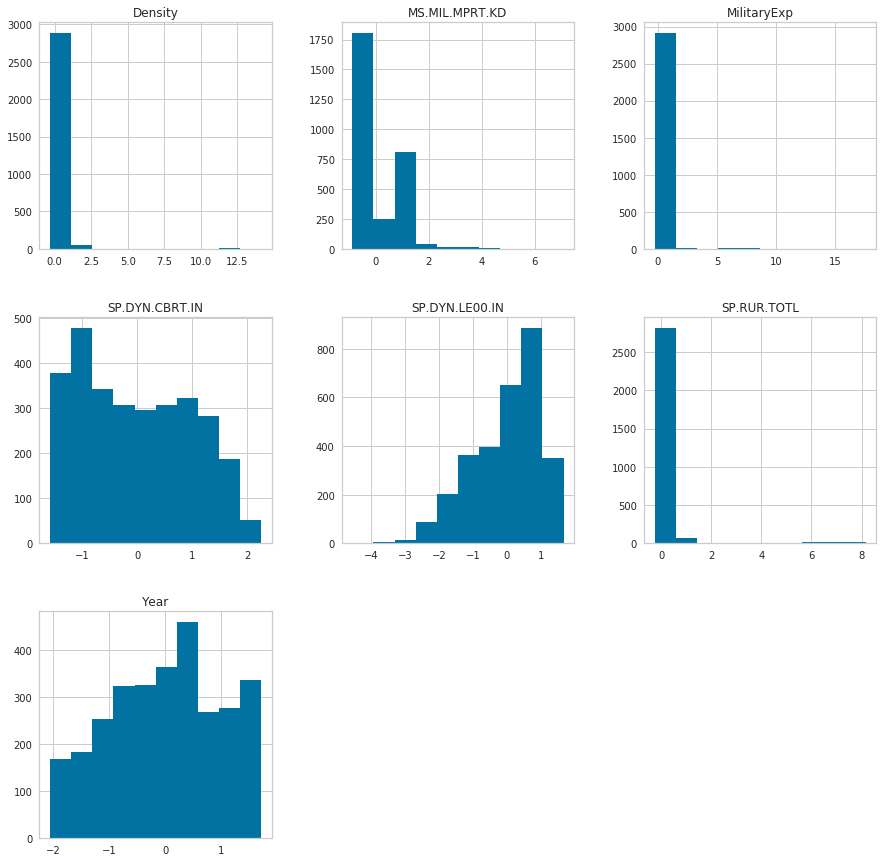

In [155]:
from sklearn.preprocessing import scale

feature_matrix=df_class.loc[:, df_std.columns != 'cnt']
target_vector=df_class['cnt']
feature_matrix = pd.DataFrame(scale(feature_matrix), index=feature_matrix.index, columns=feature_matrix.columns) # standardization
feature_matrix.hist(figsize=(15,15))



In [156]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

We first try with multinomial logistic regression

In [157]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True,random_state=1, max_iter=10000, multi_class='multinomial',solver ='newton-cg').fit(x_train, y_train)
clf.predict(x_train)
print(clf.score(x_train,y_train))

clf.predict(x_test)
print(clf.score(x_test,y_test))

0.31852791878172587
0.28716216216216217


After we try with multi-layer perceptron

In [158]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
print('train accuracy: ', accuracy_score(y_train, y_pred_train))

y_pred_test = clf.predict(x_test)
print('test accuracy: ', accuracy_score(y_test, y_pred_test))


train accuracy:  0.4606598984771574
test accuracy:  0.40033783783783783


The results are so good in respect to regression!

In [159]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred_train)

array([[225, 243,  56,   9,   9],
       [137, 427, 100,  14,  31],
       [ 47, 251, 196,  32,  26],
       [ 20,  86,  58, 121,  31],
       [ 11,  55,  18,  41, 120]])

In [160]:
confusion_matrix(y_test, y_pred_test)

array([[54, 82, 16,  0,  4],
       [33, 89, 24,  5,  7],
       [15, 74, 41, 11,  8],
       [ 1, 24, 12, 25, 11],
       [ 2, 14,  3,  9, 28]])